In [95]:
from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import visualpriors
import subprocess
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import h5py
import os
import cv2

from src.core.data_types import Dataset
from src.ai.utils import mlp_creator
from src.data.utils import load_run, load_dataset_from_hdf5, select, load_data_from_directory


In [96]:
################################################################################
# Load data                                                                    #
################################################################################
filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', f'vanilla_3x128x128.hdf5')
h5py_file = h5py.File(filename, 'r')

In [20]:
################################################################################
# Define network                                                               #
################################################################################
input_size = 8*16*16
output_size = 64*64
decoder = mlp_creator(sizes=[input_size, 2056, 2056, output_size],
                      activation=nn.ReLU,
                      output_activation=None,
                      bias_in_last_layer=False)


In [ ]:
inputs = torch.as_tensor(h5py_file['dataset']['observations'][0:1][:, :, ::2, ::2])
threshold = 0.5
targets = []
for image in inputs:
    targets.append(cv2.threshold(image.mean(axis=0, keepdims=True), 0, 1, cv2.THRESH_BINARY)[1])
    binary_images = np.asarray(binary_images)
targets = torch.as_tensor(h5py_file['dataset']['targets'][0:1][:, ::2, ::2])

In [7]:
encoder = nn.Sequential(
    nn.Conv2d(3, 32, 5, stride=2),
    nn.ReLU(),
    nn.Conv2d(32, 64, 5, stride=2),
    nn.ReLU(),
    nn.Conv2d(64, 128, 5, stride=2),
    nn.ReLU(),
    nn.Conv2d(128, 256, 5, stride=2),
    nn.ReLU()
)
decoder = nn.Sequential(
    nn.ConvTranspose2d(256, 128, 5, stride=2, padding=0),
    nn.ReLU(),
    nn.ConvTranspose2d(128, 64, 5, stride=2, padding=0),
    nn.ReLU(),
    nn.ConvTranspose2d(64, 32, 6, stride=2, padding=0),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 1, 6, stride=2, padding=0)
)
discriminator = nn.Sequential(
    nn.Conv2d(1, 32, 5, stride=2),
    nn.ReLU(),
    nn.Conv2d(32, 64, 5, stride=2),
    nn.ReLU(),
    nn.Conv2d(64, 128, 5, stride=2),
    nn.ReLU(),
    nn.Conv2d(128, 1, 5, stride=2, bias=False),
)
discriminator(decoder(encoder(inputs)))

torch.Size([50, 1, 1, 1])

In [69]:
discriminator_targets = torch.as_tensor([[1], [0]], dtype=torch.float32)
with torch.no_grad():
    feature = encoder(inputs)
    feature += 0.1 * torch.randn(feature.size())
    fake_estimates = decoder(feature)
discriminator_inputs = torch.stack([targets, fake_estimates[0]])
prediction = discriminator(discriminator_inputs).squeeze(2).squeeze(2)
loss = -discriminator_targets * prediction.log() - (1-discriminator_targets) * (1-prediction).log()

  0%|          | 0/1000 [00:00<?, ?it/s]

gen: 0.077, discr: 0.023, predmin: 0.013, predmax: 1.486, fake:  0.001, real: 0.003


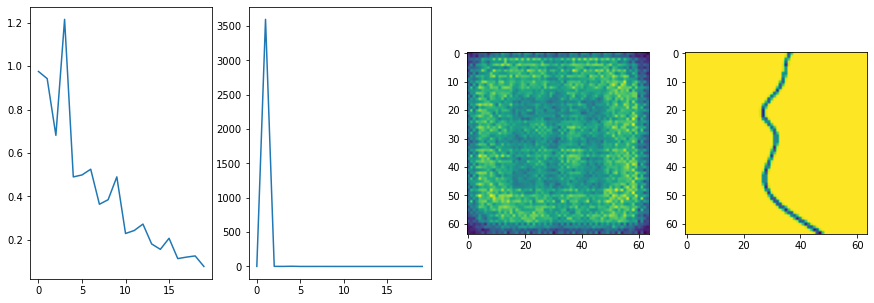

  1%|          | 10/1000 [00:11<17:13,  1.04s/it]

gen: 0.005, discr: 0.252, predmin: 0.104, predmax: 1.106, fake:  0.451, real: 0.451


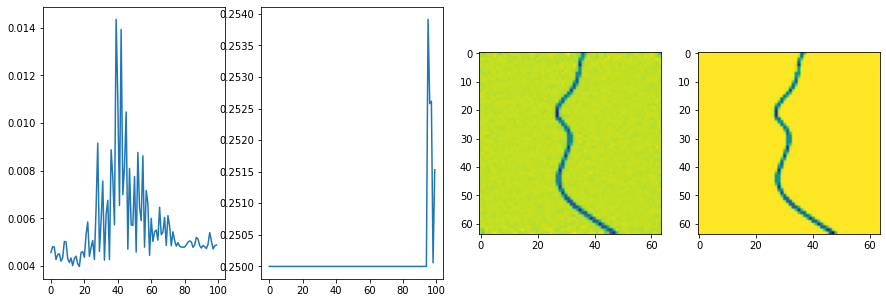

  2%|▏         | 20/1000 [00:21<16:09,  1.01it/s]

gen: 0.010, discr: 0.250, predmin: 0.078, predmax: 1.065, fake:  0.501, real: 0.501


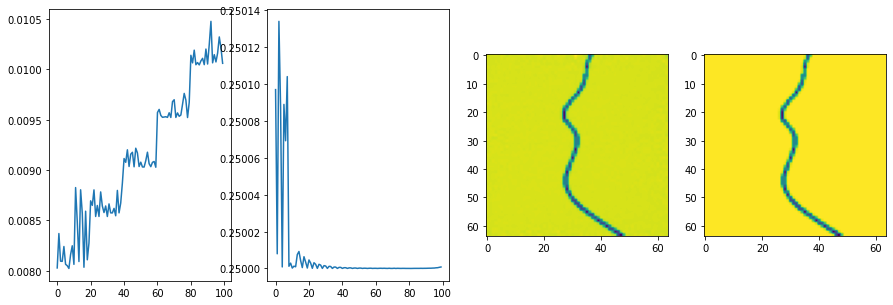

  3%|▎         | 30/1000 [00:32<17:41,  1.09s/it]

gen: 0.015, discr: 0.250, predmin: 0.075, predmax: 1.046, fake:  0.500, real: 0.500


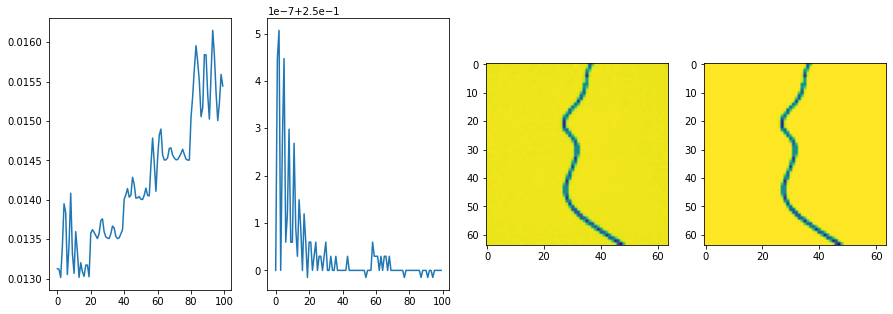

  4%|▍         | 40/1000 [00:44<17:31,  1.10s/it]

gen: 0.023, discr: 0.250, predmin: 0.086, predmax: 1.077, fake:  0.500, real: 0.500


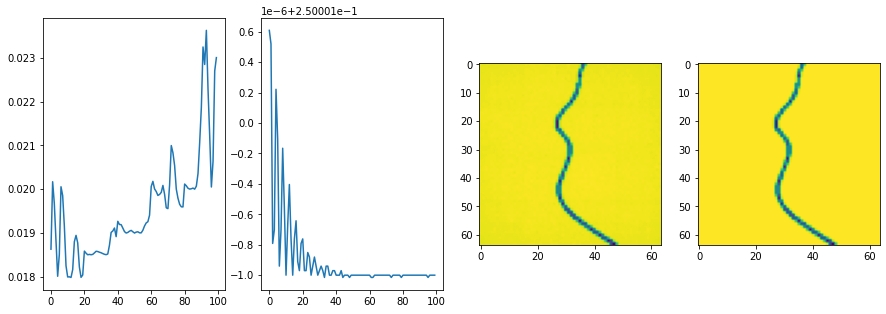

  5%|▌         | 50/1000 [00:55<16:46,  1.06s/it]

gen: 0.026, discr: 0.250, predmin: 0.073, predmax: 0.986, fake:  0.499, real: 0.499


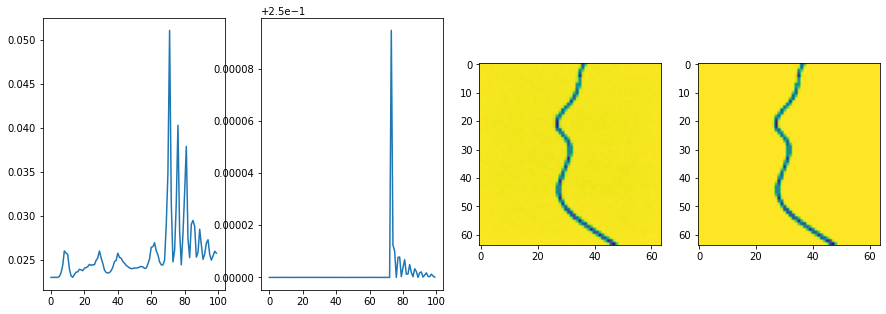

  6%|▌         | 60/1000 [01:06<16:37,  1.06s/it]

gen: 0.030, discr: 0.250, predmin: 0.078, predmax: 1.033, fake:  0.500, real: 0.500


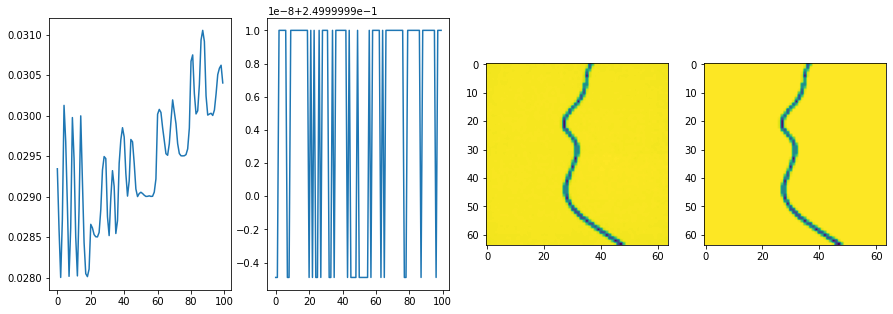

  7%|▋         | 70/1000 [01:20<22:47,  1.47s/it]

gen: 0.035, discr: 0.250, predmin: 0.072, predmax: 0.996, fake:  0.500, real: 0.500


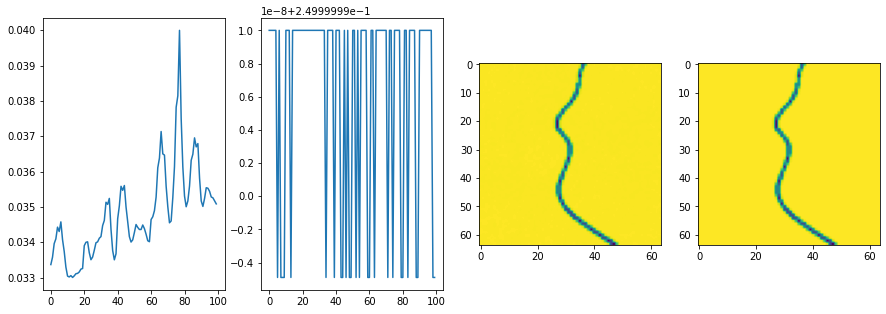

  8%|▊         | 80/1000 [01:38<29:35,  1.93s/it]

gen: 0.041, discr: 0.250, predmin: 0.082, predmax: 1.042, fake:  0.500, real: 0.500


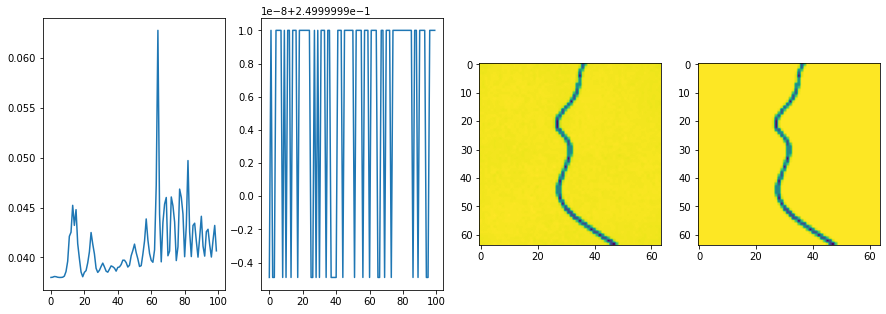

  9%|▉         | 90/1000 [02:00<33:13,  2.19s/it]

gen: 0.045, discr: 0.250, predmin: 0.072, predmax: 0.993, fake:  0.500, real: 0.500


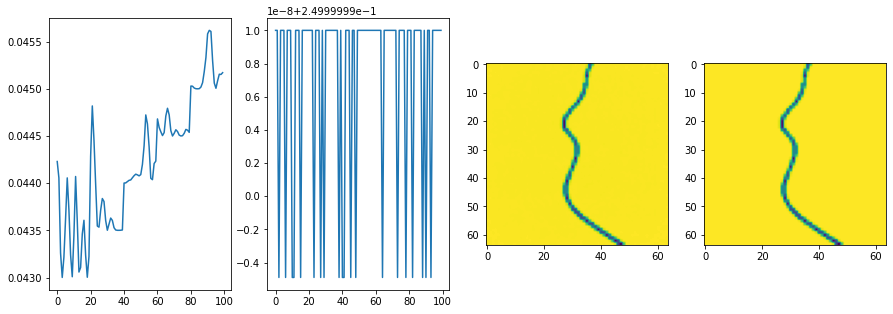

 10%|█         | 100/1000 [02:24<35:34,  2.37s/it]

gen: 0.051, discr: 0.250, predmin: 0.068, predmax: 0.975, fake:  0.500, real: 0.500


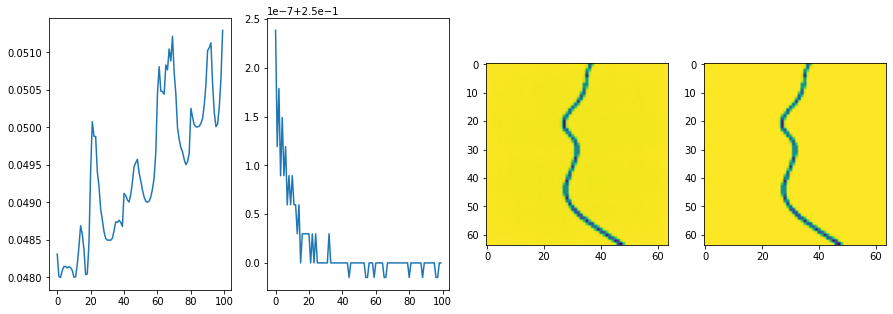

 11%|█         | 110/1000 [02:52<43:31,  2.93s/it]

gen: 0.055, discr: 0.250, predmin: 0.071, predmax: 0.993, fake:  0.500, real: 0.500


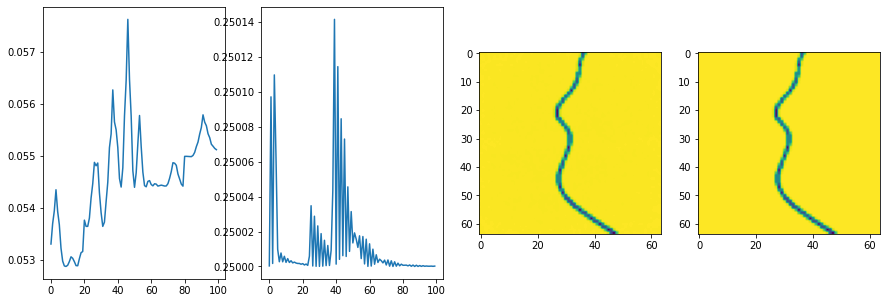

 12%|█▏        | 120/1000 [03:22<42:40,  2.91s/it]

gen: 0.061, discr: 0.250, predmin: 0.070, predmax: 0.972, fake:  0.500, real: 0.500


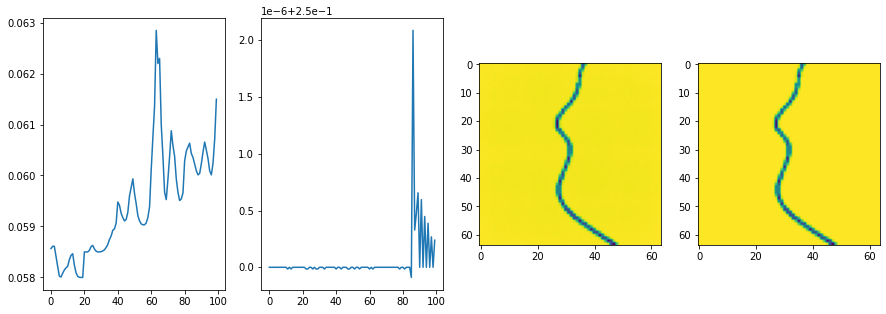

 13%|█▎        | 130/1000 [03:53<44:52,  3.10s/it]

gen: 0.065, discr: 0.250, predmin: 0.070, predmax: 0.988, fake:  0.501, real: 0.501


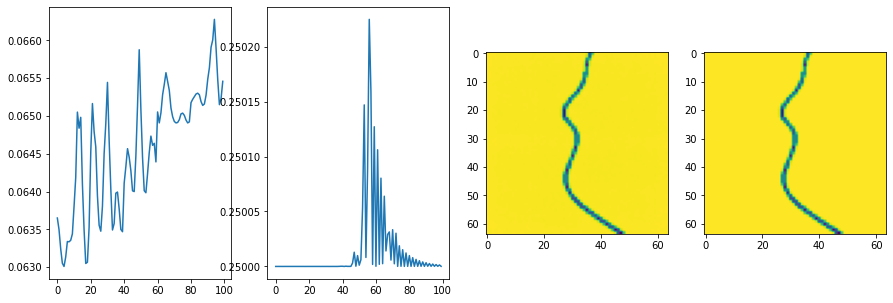

 14%|█▍        | 140/1000 [04:28<48:21,  3.37s/it]

gen: 0.070, discr: 0.250, predmin: 0.075, predmax: 1.018, fake:  0.500, real: 0.500


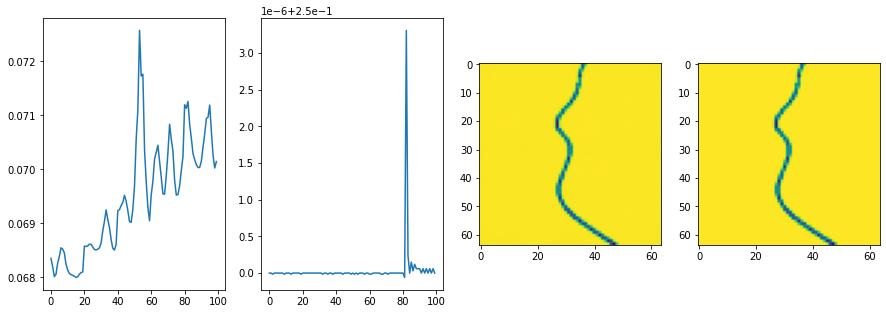

 15%|█▌        | 150/1000 [05:02<45:55,  3.24s/it]

gen: 0.075, discr: 0.250, predmin: 0.073, predmax: 0.998, fake:  0.500, real: 0.500


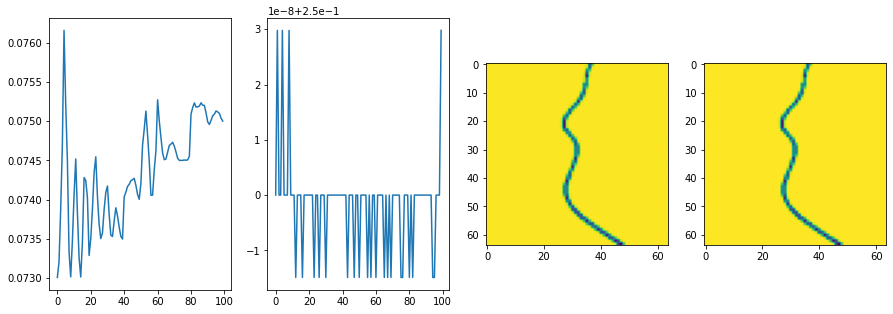

 16%|█▌        | 158/1000 [05:34<29:41,  2.12s/it]


KeyboardInterrupt: 

In [80]:
# Add a discriminator at the end

from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import visualpriors
import subprocess
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import h5py
import os
import cv2

filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', f'vanilla_3x256x256_0.hdf5')
h5py_file = h5py.File(filename, 'r')

img = h5py_file['dataset']['observations'][1000].swapaxes(0, 1).swapaxes(1, 2)
img = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_LANCZOS4)
inputs = torch.as_tensor(np.asarray(img).swapaxes(2, 1).swapaxes(0, 1)).unsqueeze(0)

img = h5py_file['dataset']['targets'][1000]
img = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_LANCZOS4)
targets = torch.as_tensor(img).unsqueeze(0)
#inputs = torch.as_tensor(h5py_file['dataset']['observations'][1000][::4, ::4]).unsqueeze(0)
#targets = torch.as_tensor(h5py_file['dataset']['targets'][1000][::4, ::4]).unsqueeze(0)

encoder = nn.Sequential(
    nn.Conv2d(3, 32, 5, stride=2),
    nn.ReLU(),
    nn.Conv2d(32, 64, 5, stride=2),
    nn.ReLU(),
    nn.Conv2d(64, 128, 5, stride=2),
    nn.ReLU(),
    nn.Conv2d(128, 256, 5, stride=2),
    nn.ReLU()
)
decoder = nn.Sequential(
    nn.ConvTranspose2d(256, 128, 5, stride=2, padding=0),
    nn.ReLU(),
    nn.ConvTranspose2d(128, 64, 5, stride=2, padding=0),
    nn.ReLU(),
    nn.ConvTranspose2d(64, 32, 6, stride=2, padding=0),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 1, 6, stride=2, padding=0)
)
discriminator = nn.Sequential(
    nn.Conv2d(1, 32, 5, stride=2),
    nn.ReLU(),
    nn.Conv2d(32, 64, 5, stride=2),
    nn.ReLU(),
    nn.Conv2d(64, 128, 5, stride=2),
    nn.ReLU(),
    nn.Conv2d(128, 1, 5, stride=2, bias=False)
)

torch.manual_seed(4)
params = list(decoder.parameters()) + list(encoder.parameters())
for p in params + list(discriminator.parameters()):
    if len(p.shape) <= 1:
        p.data.zero_()
    else:
        nn.init.xavier_uniform_(p.data)
optimizer = torch.optim.Adam(params=params, 
                             lr=0.001,
                             weight_decay=0.0001)
discriminator_optimizer = torch.optim.Adam(params=discriminator.parameters(), 
                                           lr=0.01,
                                           weight_decay=0.0001)
training_image_indices = list(range(50))
batch_size = 50

losses = []
discriminator_losses = []
train_num = 1000
for i in tqdm(range(train_num)):
    #sample_indices = np.random.choice(training_image_indices,
    #                                  size=batch_size)
    #inputs = [cv2.resize(h5py_file['dataset']['observations'][index].swapaxes(0, 1).swapaxes(1, 2), 
    #                     dsize=(64, 64), interpolation=cv2.INTER_LANCZOS4) for index in sample_indices]
    #inputs = torch.stack([torch.as_tensor(np.asarray(img).swapaxes(2,1).swapaxes(1,0)) for img in inputs])
    #targets = [cv2.resize(h5py_file['dataset']['targets'][index], 
    #                      dsize=(64, 64), interpolation=cv2.INTER_LANCZOS4) for index in sample_indices]
    #targets = torch.stack([torch.as_tensor(np.asarray(img)).unsqueeze(0) for img in targets])
    
    # train discriminator
    for p in params:
        p.requires_grad = False
    for p in discriminator.parameters():
        p.requires_grad = True
        
    for j in range(20):
        discriminator_optimizer.zero_grad()
        discriminator_targets = torch.as_tensor([[0], [1]], dtype=torch.float32)
        with torch.no_grad():
            feature = encoder(inputs)
            feature += 0.1 * torch.randn(feature.size())
            fake_estimates = decoder(feature)
        discriminator_inputs = torch.stack([targets, fake_estimates[0]])
        prediction = discriminator(discriminator_inputs).squeeze(2).squeeze(2)
        #prediction.clamp_(1e-5, 1 - 1e-5)
        loss = ((discriminator_targets.detach() - prediction)**2).mean()       
#        loss = -discriminator_targets * prediction.log() - (1-discriminator_targets) * (1-prediction).log()
        loss.mean().backward()
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=3)
        discriminator_optimizer.step()
        discriminator_losses.append(loss.mean().item())
    
    # train generator
    for p in params:
        p.requires_grad = True
    for p in discriminator.parameters():
        p.requires_grad = False

    for j in range(20):
        optimizer.zero_grad()
        feature = encoder(inputs)
        feature += 0.1 * torch.randn(feature.size())
        prediction = decoder(feature)
#        loss = ((targets.detach() - prediction)**2).mean() 
        loss = (i/train_num) * discriminator(prediction).mean() + (1-(i/train_num))*((targets.detach() - prediction)**2).mean()  
        loss.backward()
        torch.nn.utils.clip_grad_norm_(params, max_norm=3)
        optimizer.step()
        losses.append(loss.item())
    if i % 10 == 0:
        fig, axes = plt.subplots(1, 4, figsize=(15, 5))
        if i == 0:
            axes[0].plot(range(len(losses)), losses)
            axes[1].plot(range(len(discriminator_losses)), discriminator_losses)
        else:
            axes[0].plot(range(100), losses[-100:])
            axes[1].plot(range(100), discriminator_losses[-100:])
        pred = prediction[0].detach().numpy().swapaxes(0, 1).swapaxes(1, 2).squeeze()
        print(f'gen: {losses[-1]:0.3f}, discr: {discriminator_losses[-1]:0.3f}, ' 
              f'predmin: {pred.min():0.3f}, predmax: {pred.max():0.3f}, '
              f'fake: {discriminator(decoder(encoder(inputs))).item(): 0.3f}, real: {discriminator(targets.unsqueeze(0)).item():0.3f}')
        axes[2].imshow(pred)
        axes[3].imshow(targets.detach().numpy().squeeze())
        plt.show()
        plt.cla()
        plt.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

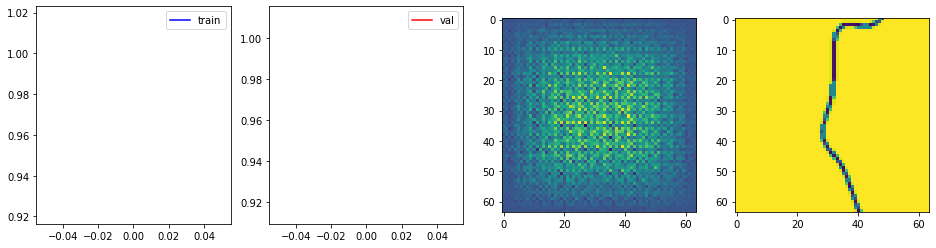

 10%|█         | 100/1000 [00:38<05:38,  2.66it/s]

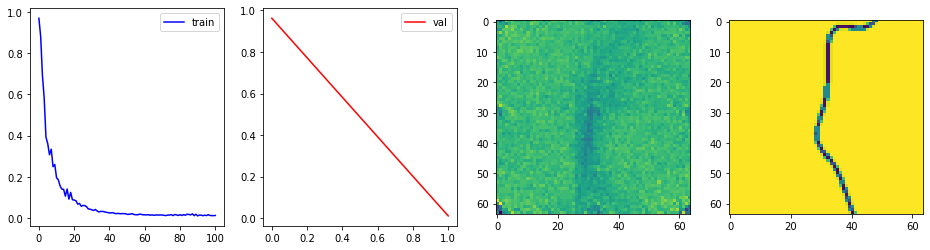

 20%|██        | 200/1000 [01:17<05:05,  2.62it/s]

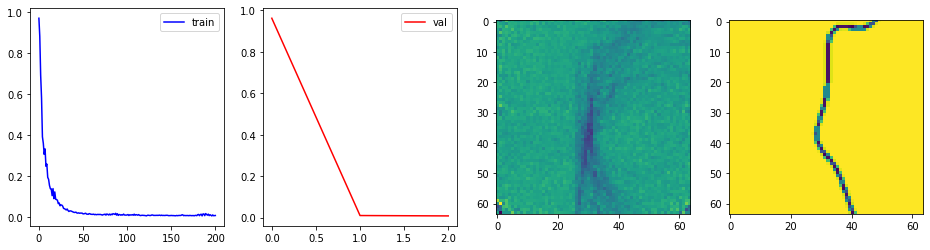

 30%|███       | 300/1000 [01:56<04:26,  2.63it/s]

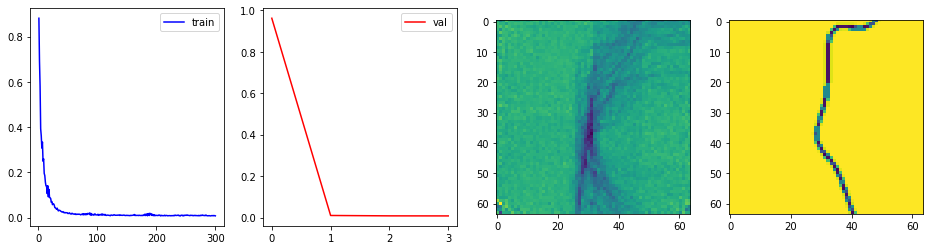

 40%|████      | 400/1000 [02:39<04:04,  2.46it/s]

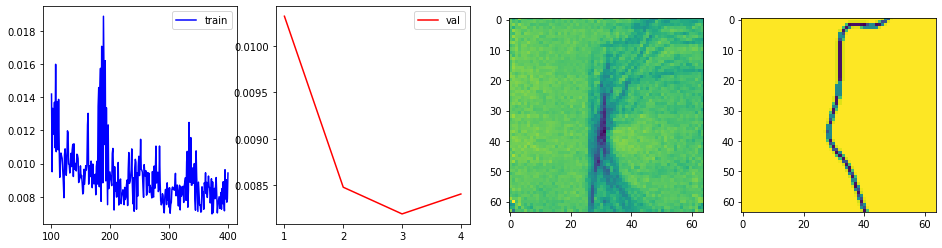

 50%|█████     | 500/1000 [03:29<05:05,  1.64it/s]

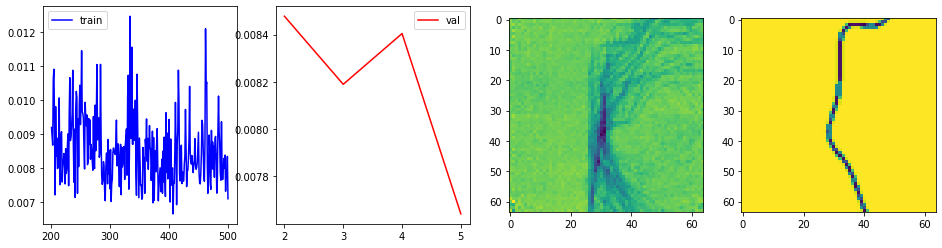

 60%|██████    | 600/1000 [04:18<02:46,  2.41it/s]

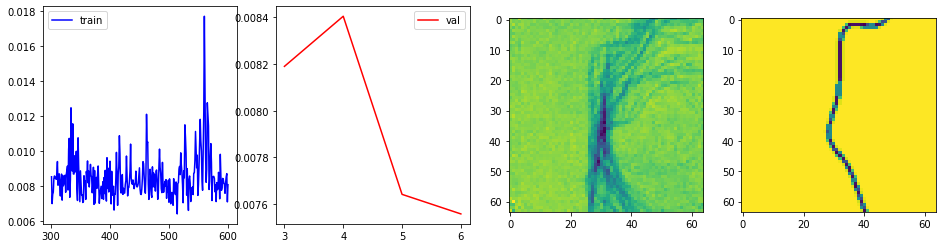

 70%|███████   | 700/1000 [04:59<02:06,  2.36it/s]

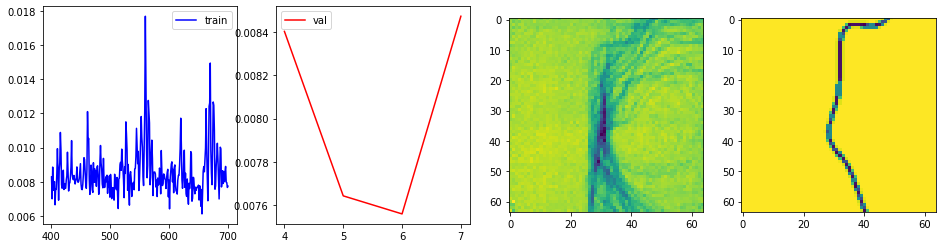

 80%|████████  | 800/1000 [05:44<01:25,  2.35it/s]

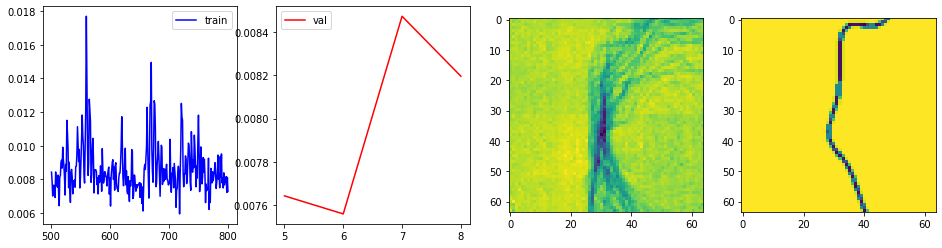

 90%|█████████ | 900/1000 [06:28<00:41,  2.39it/s]

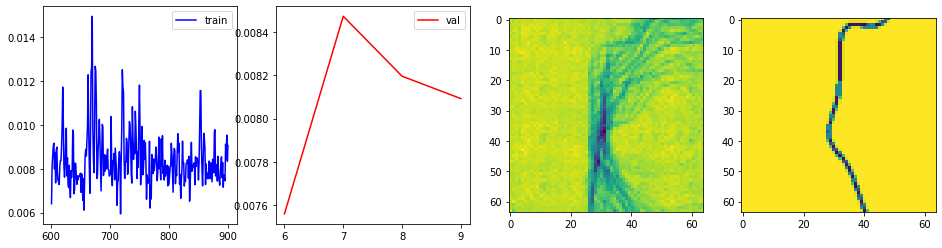

100%|██████████| 1000/1000 [07:12<00:00,  2.31it/s]


In [2]:
# TRAIN ON MANY IMAGES

from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import visualpriors
import subprocess
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import h5py
import os
import cv2

filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', f'vanilla_3x256x256_0.hdf5')
h5py_file = h5py.File(filename, 'r')

encoder = nn.Sequential(
    nn.Conv2d(3, 32, 5, stride=2),
    nn.ReLU(),
    nn.Conv2d(32, 64, 5, stride=2),
    nn.ReLU(),
    nn.Conv2d(64, 128, 5, stride=2),
    nn.ReLU(),
    nn.Conv2d(128, 256, 5, stride=2),
    nn.ReLU()
)
decoder = nn.Sequential(
    nn.ConvTranspose2d(256, 128, 5, stride=2, padding=0),
    nn.ReLU(),
    nn.ConvTranspose2d(128, 64, 5, stride=2, padding=0),
    nn.ReLU(),
    nn.ConvTranspose2d(64, 32, 6, stride=2, padding=0),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 1, 6, stride=2, padding=0)
)
torch.manual_seed(4)
params = list(decoder.parameters()) + list(encoder.parameters())
for p in params:
    if len(p.shape) <= 1:
        p.data.zero_()
    else:
        nn.init.xavier_uniform_(p.data)
optimizer = torch.optim.Adam(params=params, 
                             lr=0.001,
                             weight_decay=0.0001)
#total = len(h5py_file['dataset']['observations'])
#total = 100
#training_image_indices = np.arange(50, total)
training_image_indices = list(range(50))
batch_size = 50
#dropout = nn.Dropout(p=0.1)
dropout = None
losses = []
val_losses = []
for i in tqdm(range(1000)):
    sample_indices = np.random.choice(training_image_indices,
                                      size=batch_size)
    inputs = [cv2.resize(h5py_file['dataset']['observations'][index].swapaxes(0, 1).swapaxes(1, 2), 
                         dsize=(64, 64), interpolation=cv2.INTER_LANCZOS4) for index in sample_indices]
    inputs = torch.stack([torch.as_tensor(np.asarray(img).swapaxes(2,1).swapaxes(1,0)) for img in inputs])
    targets = [cv2.resize(h5py_file['dataset']['targets'][index], 
                          dsize=(64, 64), interpolation=cv2.INTER_LANCZOS4) for index in sample_indices]
    targets = torch.stack([torch.as_tensor(np.asarray(img)).unsqueeze(0) for img in targets])
    for j in range(1):
        optimizer.zero_grad()
        feature = encoder(inputs)
        if dropout is not None:
            feature = dropout(feature)
        feature += 2*torch.randn(feature.size())
        prediction = decoder(feature)
    #    loss = (targets.detach() - prediction).abs().mean()
        loss = ((targets.detach() - prediction)**2).mean()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(params, max_norm=3)
        optimizer.step()
    losses.append(loss.item())
    
    if i % 100 == 0:
        # Validate
        inputs = [cv2.resize(h5py_file['dataset']['observations'][index].swapaxes(0, 1).swapaxes(1, 2), 
                             dsize=(64, 64), interpolation=cv2.INTER_LANCZOS4) for index in range(50)]
        inputs = torch.stack([torch.as_tensor(np.asarray(img).swapaxes(2,1).swapaxes(1,0)) for img in inputs])
        targets = [cv2.resize(h5py_file['dataset']['targets'][index], 
                              dsize=(64, 64), interpolation=cv2.INTER_LANCZOS4) for index in range(50)]
        targets = torch.stack([torch.as_tensor(np.asarray(img)).unsqueeze(0) for img in targets])
        feature = encoder(inputs)
        prediction = decoder(feature)
        #loss = (targets.detach() - prediction).abs().mean()
        loss = ((targets.detach() - prediction)**2).mean()
        val_losses.append(loss.item())
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        axes[0].plot(range(len(losses)) if len(losses) < 300 else range(len(losses) - 300, len(losses)),
                     losses if len(losses) < 300 else losses[-300:], 'b', label='train')
        axes[0].legend()
        axes[1].plot(range(len(val_losses)) if len(val_losses) < 4 else range(len(val_losses) - 4, len(val_losses)),
                     val_losses if len(val_losses) < 4 else val_losses[-4:], 'r', label='val')
        axes[1].legend()
        pred = prediction[30].detach().numpy().swapaxes(0, 1).swapaxes(1, 2).squeeze()
        axes[2].imshow(pred)
        axes[3].imshow(targets[30].detach().numpy().squeeze())
        plt.show()
        plt.cla()
        plt.close()

  0%|          | 0/2000 [00:00<?, ?it/s]

-0.0057987818 0.005615033


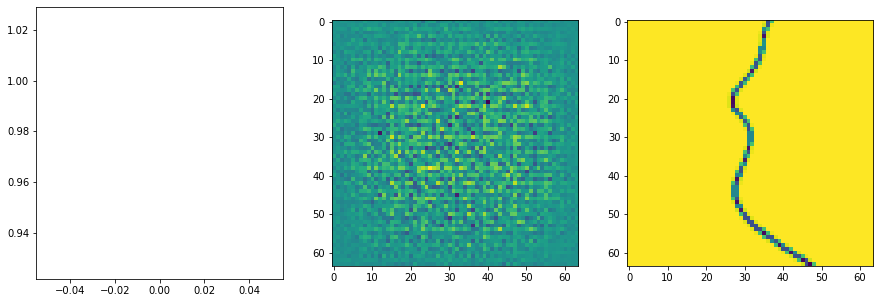

  5%|▍         | 99/2000 [00:03<01:03, 29.86it/s]

0.1468671 1.1755921


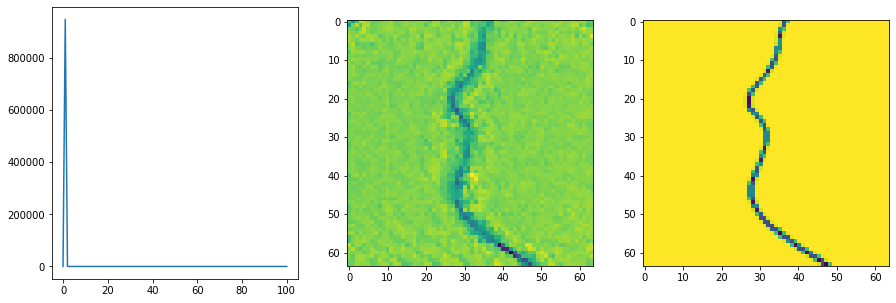

 10%|▉         | 198/2000 [00:08<01:05, 27.45it/s]

0.119106874 1.2016137


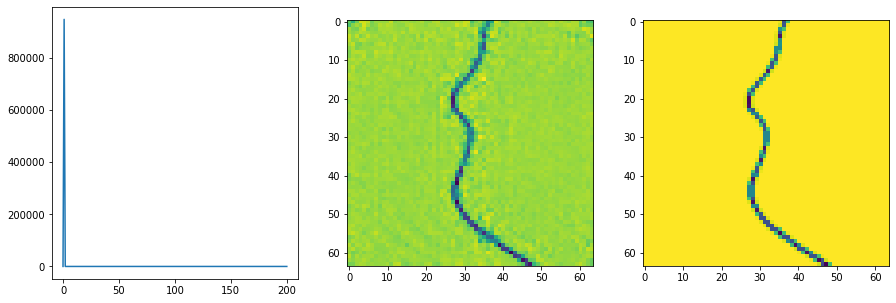

 15%|█▌        | 300/2000 [00:12<01:14, 22.92it/s]

0.09023419 1.1066716


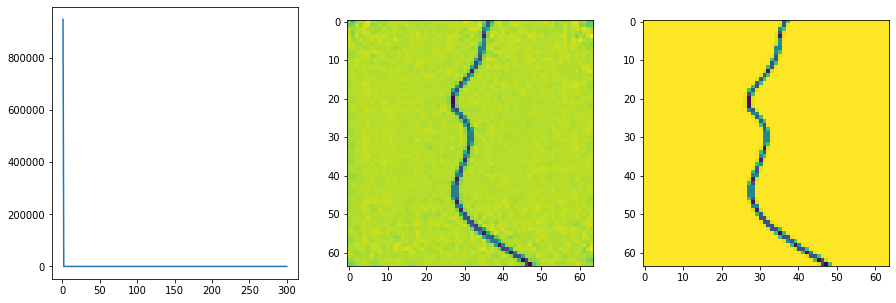

 20%|█▉        | 399/2000 [00:16<00:59, 27.04it/s]

0.20548907 1.0545537


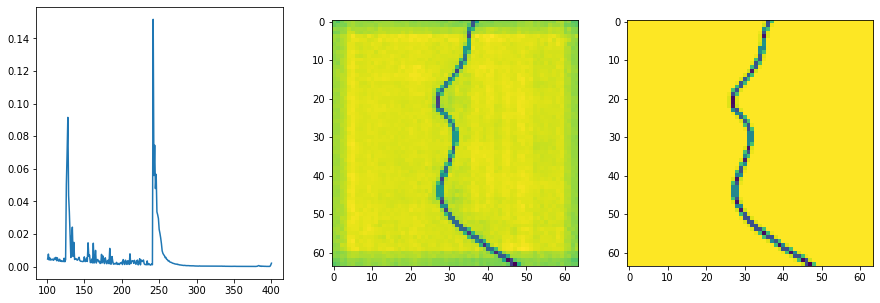

 25%|██▍       | 498/2000 [00:21<01:00, 24.99it/s]

0.07699978 1.0254455


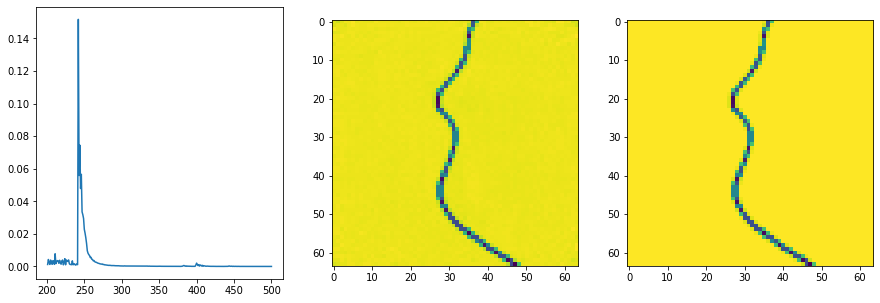

 30%|███       | 600/2000 [00:25<01:05, 21.34it/s]

0.045178622 1.028634


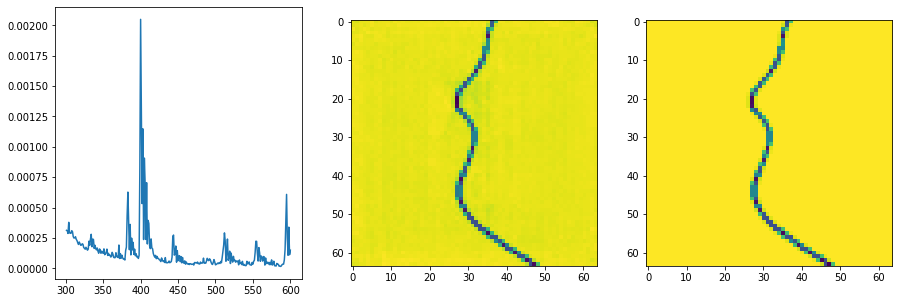

 35%|███▍      | 699/2000 [00:30<00:53, 24.16it/s]

0.07962975 1.0164243


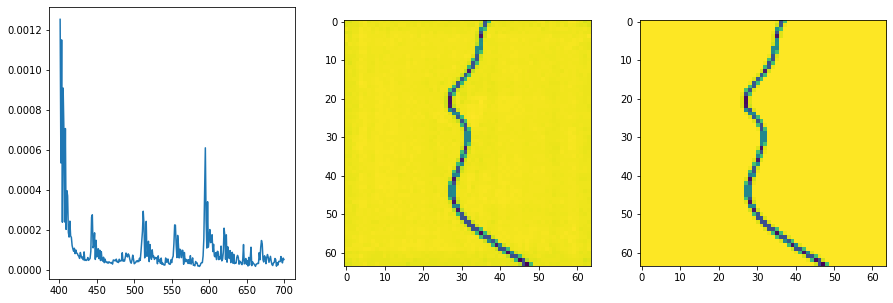

 40%|███▉      | 798/2000 [00:34<00:47, 25.49it/s]

0.062844455 1.0214573


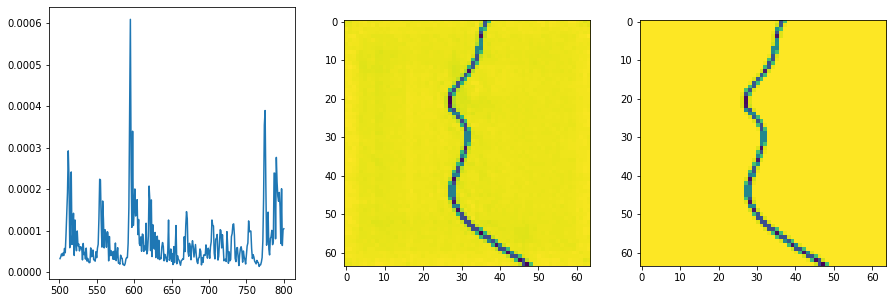

 45%|████▌     | 900/2000 [00:38<00:38, 28.23it/s]

0.08618531 1.010937


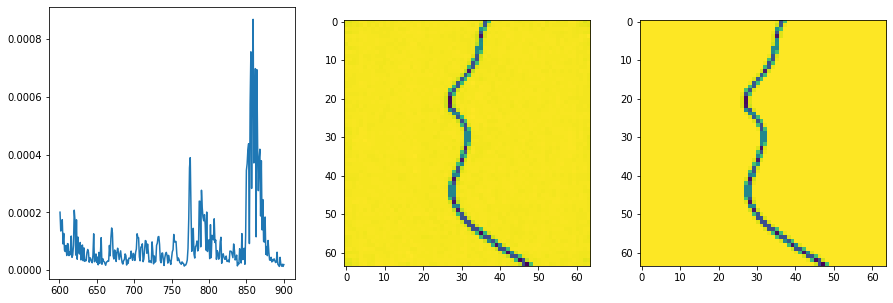

 50%|████▉     | 999/2000 [00:43<00:35, 28.10it/s]

0.08925307 1.0252696


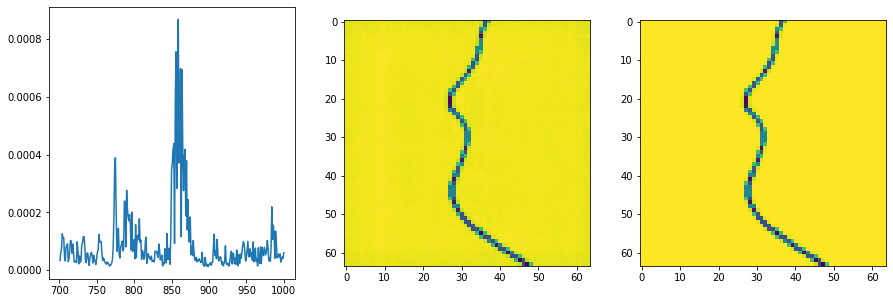

 55%|█████▍    | 1098/2000 [00:47<00:42, 21.45it/s]

0.067433834 1.022258


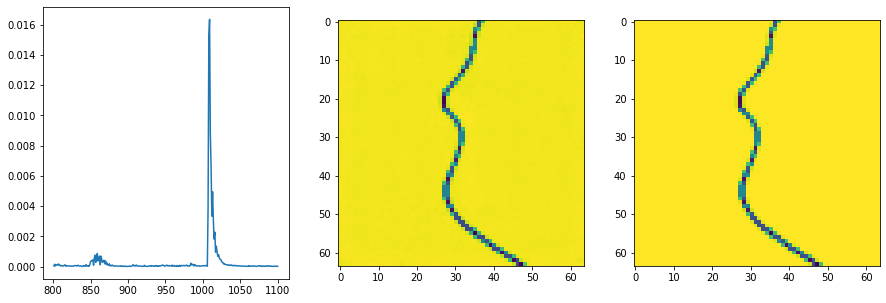

 60%|█████▉    | 1199/2000 [00:52<00:32, 24.80it/s]

0.07621917 1.0109812


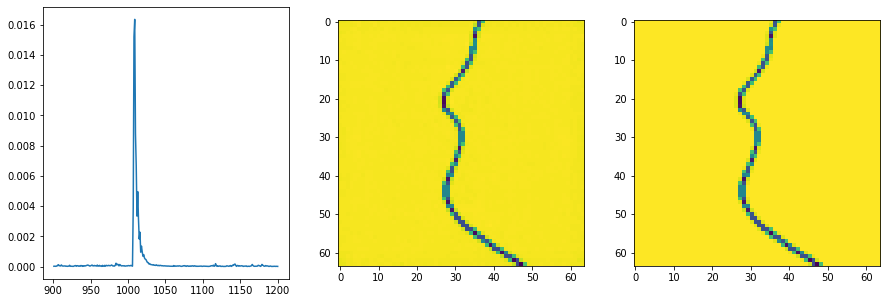

 65%|██████▍   | 1296/2000 [00:57<00:31, 22.57it/s]


KeyboardInterrupt: 

In [3]:
# One image leaky ReLU
from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import visualpriors
import subprocess
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import h5py
import os
import cv2

filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', f'vanilla_3x256x256_0.hdf5')
h5py_file = h5py.File(filename, 'r')

img = h5py_file['dataset']['observations'][1000].swapaxes(0, 1).swapaxes(1, 2)
img = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_LANCZOS4)
inputs = torch.as_tensor(np.asarray(img).swapaxes(2, 1).swapaxes(0, 1)).unsqueeze(0)

img = h5py_file['dataset']['targets'][1000]
img = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_LANCZOS4)
targets = torch.as_tensor(img).unsqueeze(0)
#inputs = torch.as_tensor(h5py_file['dataset']['observations'][1000][::4, ::4]).unsqueeze(0)
#targets = torch.as_tensor(h5py_file['dataset']['targets'][1000][::4, ::4]).unsqueeze(0)

encoder = nn.Sequential(
    nn.Conv2d(3, 32, 5, stride=2),
    nn.ReLU(),
    nn.Conv2d(32, 64, 5, stride=2),
    nn.ReLU(),
    nn.Conv2d(64, 128, 5, stride=2),
    nn.ReLU(),
    nn.Conv2d(128, 256, 5, stride=2),
    nn.ReLU()
)
decoder = nn.Sequential(
    nn.ConvTranspose2d(256, 128, 5, stride=2, padding=0),
    nn.ReLU(),
    nn.ConvTranspose2d(128, 64, 5, stride=2, padding=0),
    nn.ReLU(),
    nn.ConvTranspose2d(64, 32, 6, stride=2, padding=0),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 1, 6, stride=2, padding=0)
)
torch.manual_seed(4)
params = list(decoder.parameters()) + list(encoder.parameters())
for p in params:
    if len(p.shape) <= 1:
        p.data.zero_()
    else:
        nn.init.xavier_uniform_(p.data)
optimizer = torch.optim.Adam(params=params, 
                             lr=0.01,
                             weight_decay=0.0001)
#dropout = nn.Dropout(p=0.1)
dropout = None
losses = []
for i in tqdm(range(2000)):
    #print(f'epoch: {i}')
    optimizer.zero_grad()
    feature = encoder(inputs)
    if dropout is not None:
        feature = dropout(feature)
    feature += 0.1 * torch.randn(feature.size())
    prediction = decoder(feature)
    loss = ((targets.detach() - prediction)**2).mean()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(params, max_norm=3)
    optimizer.step()
    losses.append(loss.item())
    if i % 100 == 0:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].plot(range(len(losses)) if len(losses) < 300 else range(len(losses) - 300, len(losses)),
                     losses if len(losses) < 300 else losses[-300:])
        pred = prediction[0].detach().numpy().swapaxes(0, 1).swapaxes(1, 2).squeeze()
        print(pred.min(), pred.max())
        axes[1].imshow(pred)
        axes[2].imshow(targets.detach().numpy().squeeze())
        plt.show()
        plt.cla()
        plt.close()

  0%|          | 0/2000 [00:00<?, ?it/s]

-0.0057987818 0.005615033


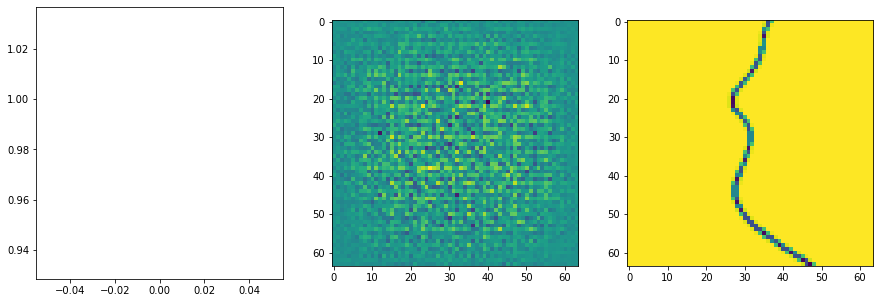

  5%|▌         | 100/2000 [00:04<01:10, 27.08it/s]

0.73059225 1.246074


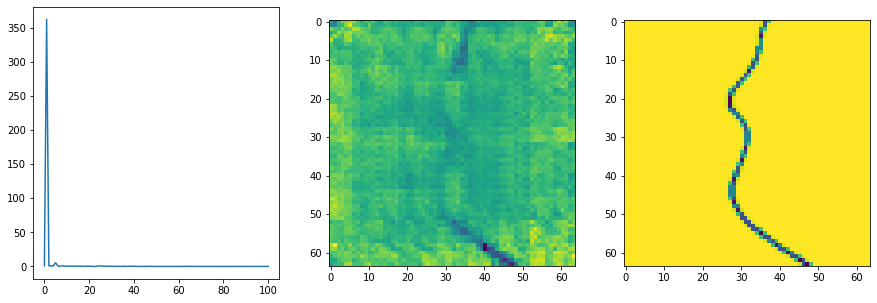

 10%|█         | 200/2000 [00:08<01:02, 28.95it/s]

0.092867464 1.074799


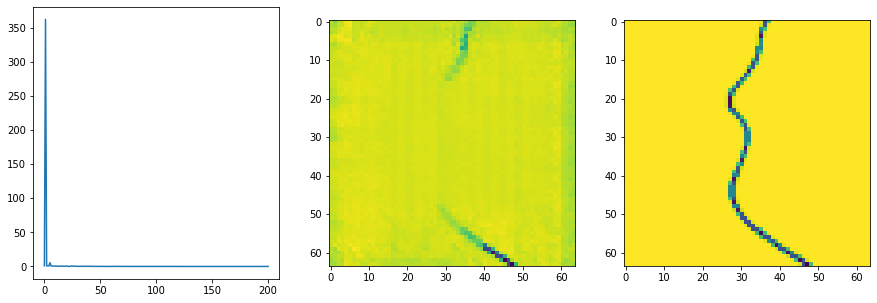

 15%|█▍        | 299/2000 [00:12<01:09, 24.45it/s]

0.03593132 1.0556471


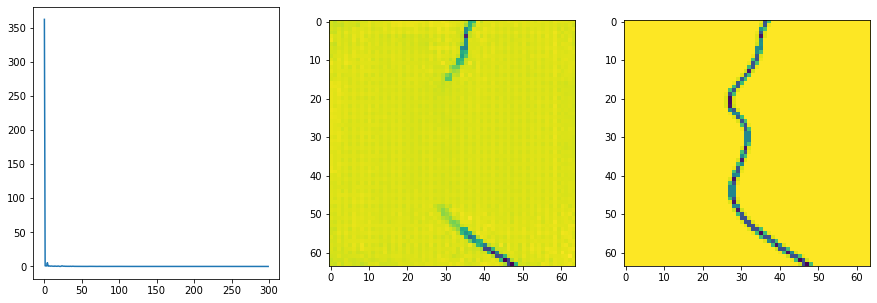

 20%|█▉        | 398/2000 [00:16<01:03, 25.36it/s]

-0.0072640777 1.0626165


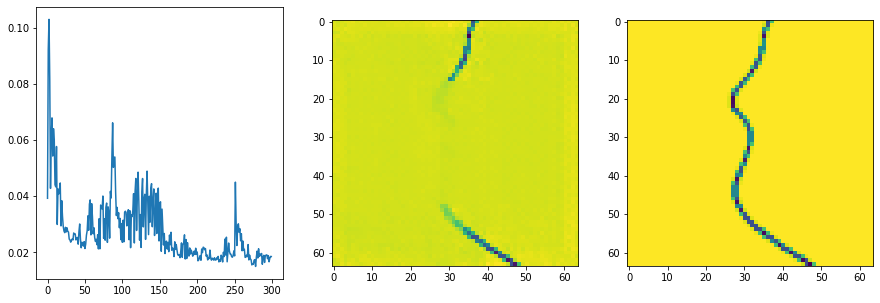

 25%|██▍       | 499/2000 [00:20<00:57, 26.20it/s]

0.086799294 1.0614898


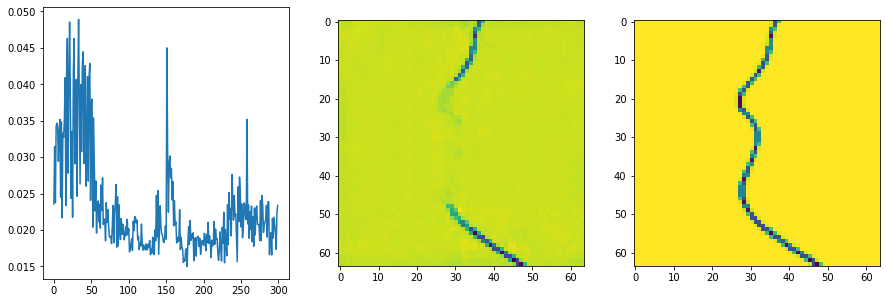

 30%|██▉       | 598/2000 [00:25<00:58, 23.96it/s]

0.07897812 1.0379055


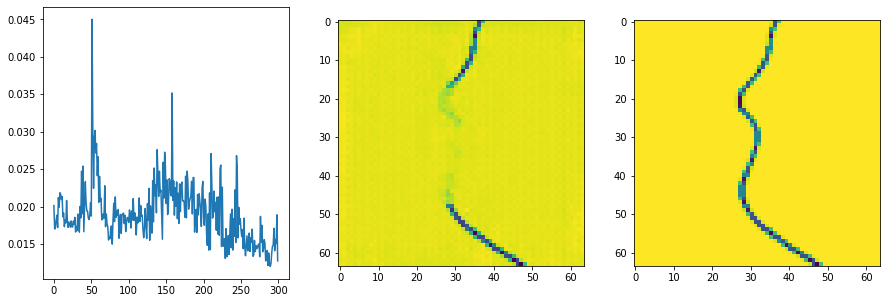

 35%|███▌      | 700/2000 [00:30<00:56, 23.12it/s]

0.12969562 1.0467113


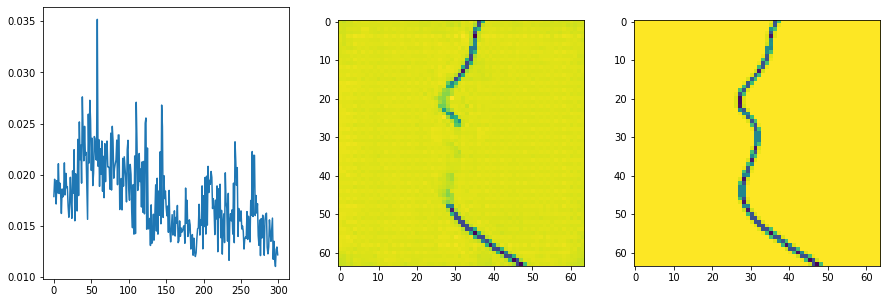

 40%|███▉      | 799/2000 [00:34<00:45, 26.35it/s]

0.0599342 1.0827128


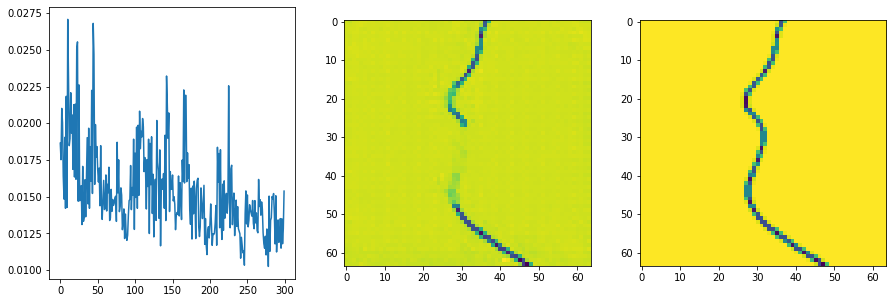

 45%|████▍     | 898/2000 [00:39<00:53, 20.75it/s]

0.08915353 1.0441682


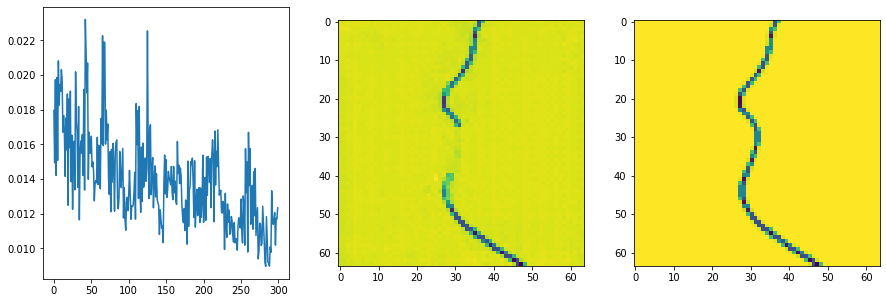

 50%|█████     | 1000/2000 [00:43<00:40, 24.41it/s]

0.16047221 1.0978448


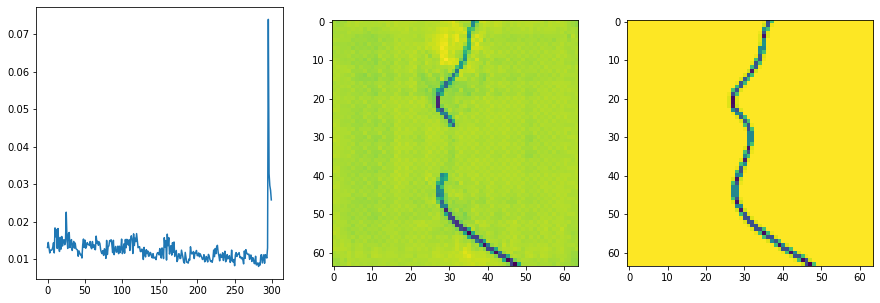

 55%|█████▍    | 1099/2000 [00:47<00:34, 26.03it/s]

-0.17689776 1.1038696


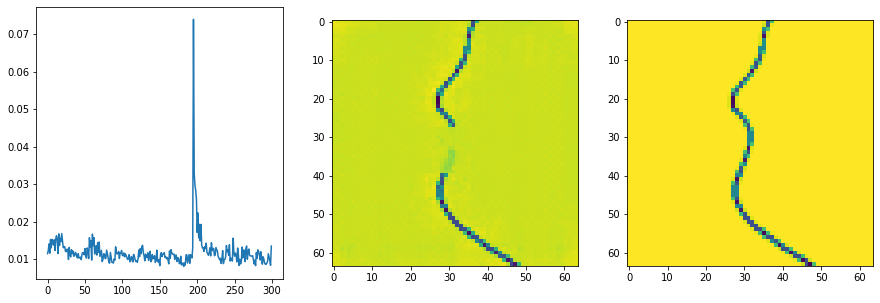

 60%|█████▉    | 1198/2000 [00:52<00:30, 26.32it/s]

0.12484911 1.0276717


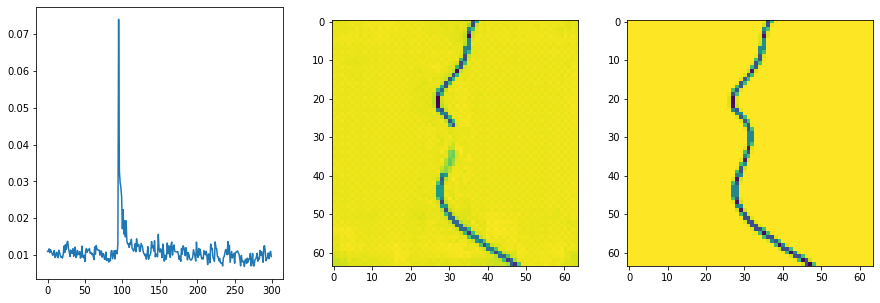

 65%|██████▌   | 1300/2000 [00:57<00:38, 18.21it/s]

-0.002539456 1.0770493


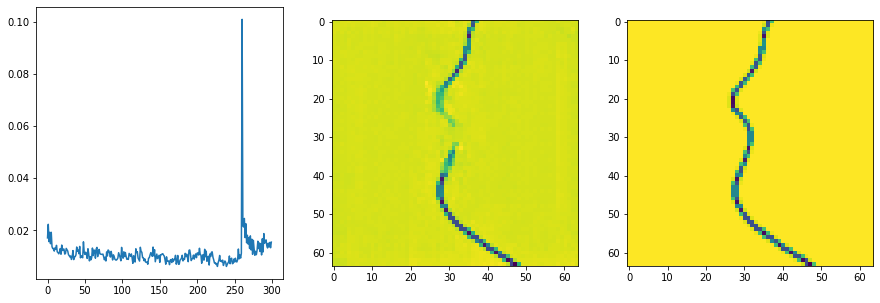

 70%|███████   | 1400/2000 [01:04<00:40, 14.68it/s]

-0.005430758 1.0618842


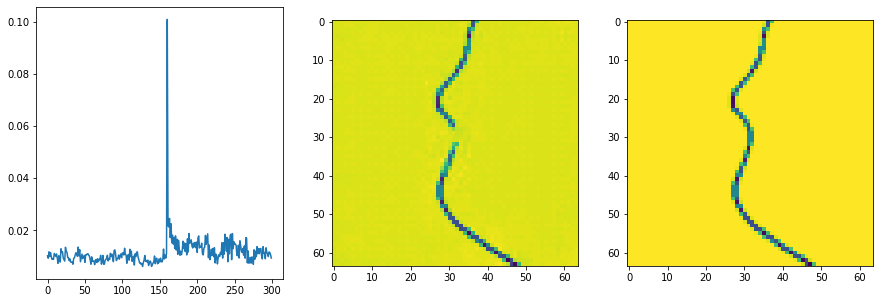

 75%|███████▌  | 1500/2000 [01:11<00:37, 13.49it/s]

0.077168226 1.0544987


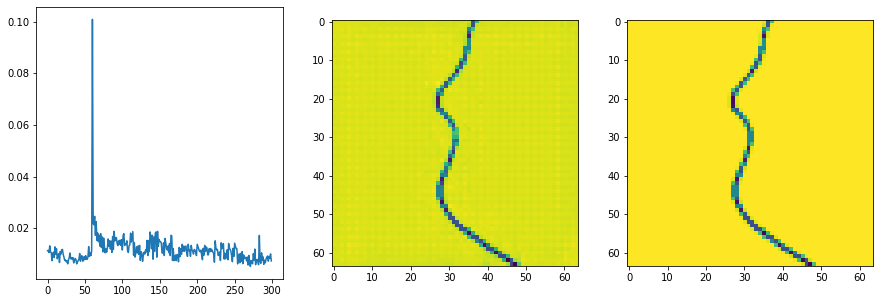

 80%|████████  | 1600/2000 [01:19<00:31, 12.60it/s]

-0.02972877 1.0180373


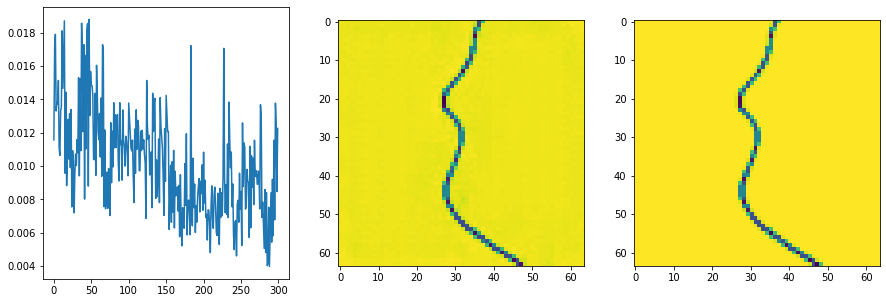

 85%|████████▌ | 1700/2000 [01:28<00:25, 11.60it/s]

0.10467571 1.0391225


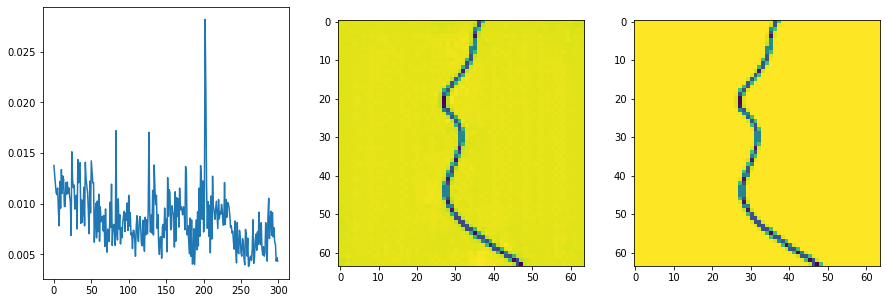

 90%|█████████ | 1800/2000 [01:37<00:17, 11.70it/s]

0.07009369 1.0324779


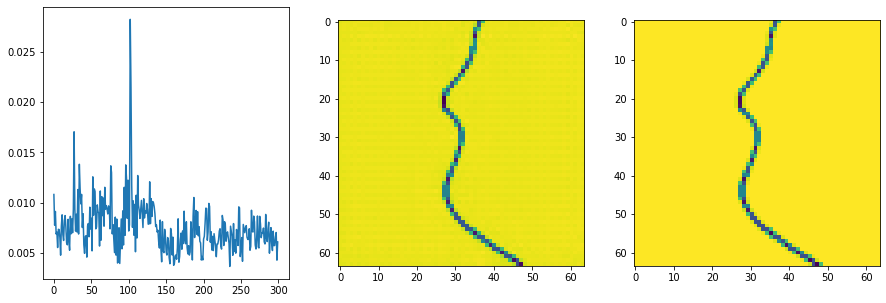

 95%|█████████▌| 1900/2000 [01:47<00:09, 10.52it/s]

-0.03953433 1.054054


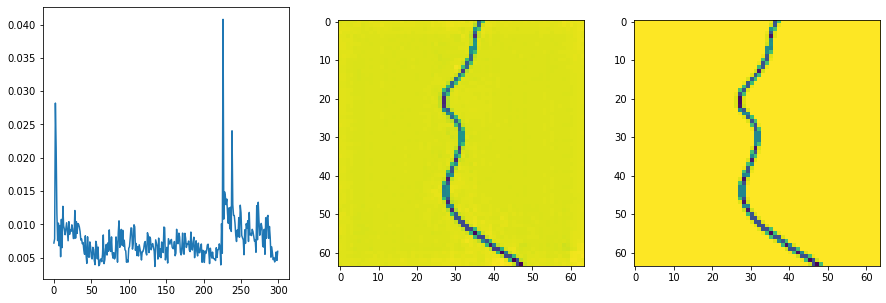

100%|█████████▉| 1999/2000 [01:57<00:00, 10.54it/s]

KeyboardInterrupt: 

In [199]:
# One image cross entropy
from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import visualpriors
import subprocess
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import h5py
import os
import cv2

filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', f'vanilla_3x256x256_0.hdf5')
h5py_file = h5py.File(filename, 'r')

img = h5py_file['dataset']['observations'][1000].swapaxes(0, 1).swapaxes(1, 2)
img = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_LANCZOS4)
inputs = torch.as_tensor(np.asarray(img).swapaxes(2, 1).swapaxes(0, 1)).unsqueeze(0)

img = h5py_file['dataset']['targets'][1000]
img = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_LANCZOS4)
targets = torch.as_tensor(img).unsqueeze(0)
#inputs = torch.as_tensor(h5py_file['dataset']['observations'][1000][::4, ::4]).unsqueeze(0)
#targets = torch.as_tensor(h5py_file['dataset']['targets'][1000][::4, ::4]).unsqueeze(0)

encoder = nn.Sequential(
    nn.Conv2d(3, 32, 5, stride=2),
    nn.ReLU(),
    nn.Conv2d(32, 64, 5, stride=2),
    nn.ReLU(),
    nn.Conv2d(64, 128, 5, stride=2),
    nn.ReLU(),
    nn.Conv2d(128, 256, 5, stride=2),
    nn.ReLU()
)
decoder = nn.Sequential(
    nn.ConvTranspose2d(256, 128, 5, stride=2, padding=0),
    nn.ReLU(),
    nn.ConvTranspose2d(128, 64, 5, stride=2, padding=0),
    nn.ReLU(),
    nn.ConvTranspose2d(64, 32, 6, stride=2, padding=0),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 1, 6, stride=2, padding=0)
)
torch.manual_seed(4)
params = list(decoder.parameters()) + list(encoder.parameters())
for p in params:
    if len(p.shape) <= 1:
        p.data.zero_()
    else:
        nn.init.xavier_uniform_(p.data)
optimizer = torch.optim.Adam(params=params, 
                             lr=0.01,
                             weight_decay=0.0001)
#dropout = nn.Dropout(p=0.1)
dropout = None
losses = []
for i in tqdm(range(2000)):
    #print(f'epoch: {i}')
    optimizer.zero_grad()
    feature = encoder(inputs)
    if dropout is not None:
        feature = dropout(feature)
    feature += 0.1 * torch.randn(feature.size())
    prediction = decoder(feature).clamp(0, 1)
    loss = (-targets * prediction.log() - (1 - targets) * (1 - prediction).log()).mean()
    #loss = (targets.detach() - prediction).abs().mean()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(params, max_norm=3)
    optimizer.step()
    losses.append(loss.item())
    if i % 100 == 0:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].plot(losses if len(losses) < 300 else losses[-300:])
        pred = prediction[0].detach().numpy().swapaxes(0, 1).swapaxes(1, 2).squeeze()
        print(pred.min(), pred.max())
        axes[1].imshow(pred)
        axes[2].imshow(targets.detach().numpy().squeeze())
        plt.show()
        plt.cla()
        plt.close()

  0%|          | 0/2000 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.022569664 0.028071769


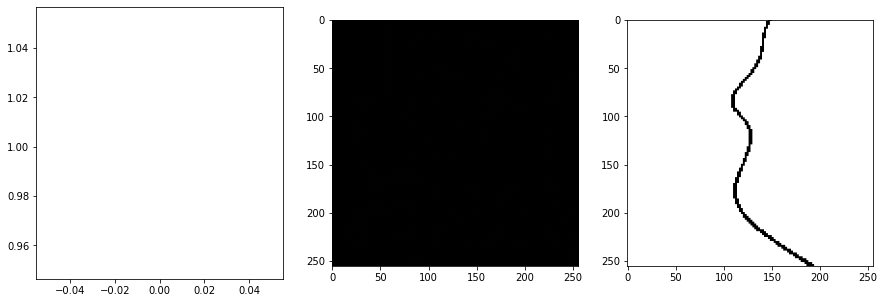

  0%|          | 5/2000 [00:08<53:28,  1.61s/it]


KeyboardInterrupt: 

In [180]:
from PIL import Image
import torchvision.transforms.functional as TF
from visualpriors.transforms import VisualPriorRepresentation
import matplotlib.pyplot as plt
import visualpriors
import subprocess
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import h5py
import os, sys
import cv2

filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', f'vanilla_3x256x256_0.hdf5')
h5py_file = h5py.File(filename, 'r')

inputs = torch.as_tensor(h5py_file['dataset']['observations'][1000]).unsqueeze(0)
feature_type = 'normal'
VisualPriorRepresentation._load_unloaded_nets([feature_type])
encoder = VisualPriorRepresentation.feature_task_to_net[feature_type]
decoder = nn.Sequential(
    nn.ConvTranspose2d(8, 4, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.ConvTranspose2d(4, 4, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.ConvTranspose2d(4, 4, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.ConvTranspose2d(4, 3, 4, stride=2, padding=1),
)

torch.manual_seed(4)
params = list(decoder.parameters()) + list(encoder.parameters())
for p in encoder.parameters():
    p.requires_grad = True
    
#for p in decoder.parameters():
for p in params:
    if len(p.shape) <= 1:
        p.data.zero_()
    else:
        nn.init.xavier_uniform_(p.data)
optimizer = torch.optim.Adam(params=params, 
                             lr=0.001,
                             weight_decay=0.00001)
dropout = nn.Dropout(p=0.1)
dropout = None
losses = []
for i in tqdm(range(2000)):
    #print(f'epoch: {i}')
    optimizer.zero_grad()
#    inputs = torch.as_tensor(h5py_file['dataset']['observations'][0:1][:, :, ::4, ::4])
    feature = encoder(inputs)
    if dropout is not None:
        feature = dropout(feature)
        
    feature += 0.1 * torch.randn(feature.size())
    prediction = decoder(feature)
#    targets = torch.as_tensor(h5py_file['dataset']['targets'][0:1][:, ::4, ::4])
    loss = ((inputs.detach() - prediction)**2).mean()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(params, max_norm=3)
    optimizer.step()
    losses.append(loss.item())
    if i % 100 == 0:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].plot(losses if len(losses) <= 300 else losses[-300:])
        pred = prediction[0].detach().numpy().swapaxes(0, 1).swapaxes(1, 2).squeeze()
        print(pred.min(), pred.max())
        axes[1].imshow(pred)
        axes[2].imshow(inputs[0].detach().numpy().swapaxes(0, 1).swapaxes(1, 2).squeeze())
        plt.show()
        plt.cla()
        plt.close()

In [21]:
################################################################################
# Take some training steps                                                     #
################################################################################
batch_size = 32
learning_rate = 0.00001
N = 10
total = len(h5py_file['dataset']['observations'])
feature_type = 'normal'
optimizer = torch.optim.Adam(params=decoder.parameters(), lr=learning_rate)
losses = []
for epoch in tqdm(range(N)):
    optimizer.zero_grad()
    sample_indices = np.random.choice(list(range(total)),
                                      size=batch_size)
    observations = [torch.as_tensor(h5py_file['dataset']['observations'][i], dtype=torch.float32) for i in sample_indices]
    targets = [torch.as_tensor(h5py_file['dataset']['targets'][i], dtype=torch.float32)[:, ::2, ::2] for i in sample_indices]
    representation = visualpriors.representation_transform(torch.stack(observations), feature_type, device='cpu')
    predictions = decoder(representation.view(-1, 2048)).view(-1, 64, 64)
    loss = (torch.stack(targets) - predictions).abs().sum()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f'epoch {epoch}, loss: {loss.item()}')
observations = None
representation = None
predictions = None
targets = None

 10%|█         | 1/10 [00:04<00:44,  4.92s/it]

epoch 0, loss: 4120011.25


 20%|██        | 2/10 [00:09<00:39,  4.95s/it]

epoch 1, loss: 4114778.0


KeyboardInterrupt: 

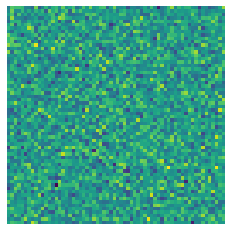

In [22]:
################################################################################
# Predict on real validation images                                            #
################################################################################
output_path = '/tmp/out'
os.makedirs(output_path, exist_ok=True)

validation_runs = [os.path.join(os.environ['DATADIR'], 'line_world_data', 'real', 'raw_data', d, 'raw_data', sd, 'observation') 
                   for d in ['concrete_bluecable', 'concrete_orangecable', 'concrete_whitecable', 'grass_bluecable', 'grass_orangecable']
                   for sd in os.listdir(os.path.join(os.environ['DATADIR'], 'line_world_data', 'real', 'raw_data', d, 'raw_data'))]
fig_counter = 0
for run in validation_runs[0:1]:
    data = load_data_from_directory(run, size=(3,256,256))[1][::20]    
    representation = visualpriors.representation_transform(torch.stack(data), feature_type, device='cpu')
    with torch.no_grad():
        predictions = decoder(representation.view(-1, 2048)).view(-1, 64, 64).detach().numpy()
    for pred in predictions:        
        plt.imshow(pred)
        plt.axis('off')
        plt.savefig(os.path.join(output_path, f'{fig_counter:010d}.jpg'))
        fig_counter += 1


In [3]:
################################################################################
# Create binary dataset with 3x256x256 input and 1x128x128 binary output       #
# input should be in range of -1:1
################################################################################

for group_index in range(3):
    filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', 'vanilla_3x128x128.hdf5')
    h5py_file = h5py.File(filename, 'r')
    amount = 3000
    
    print(f'group: {group_index}')
    observations = h5py_file['dataset']['observations'][group_index*amount:(1+group_index)*amount]
    h5py_file.close()
    
    print('extract binary target images')
    threshold = 0.5
    binary_images = []
    for image in tqdm(observations):
        binary_images.append(cv2.threshold(image.mean(axis=0, keepdims=True), 0.5, 1, cv2.THRESH_BINARY)[1])
    binary_images = np.asarray(binary_images)
    
    # ensure not everything is white
    assert binary_images[0].sum() != binary_images[0].shape[1] * binary_images[0].shape[2]
    h5py_file = None
    observations = None
    
    print('augment input image with three color noise')
    noise_augmented_images = []
    target_images = []
    size = (3, 256, 256)
    for image in tqdm(binary_images):
        image = image.squeeze()
        image = cv2.resize(image, dsize=(size[1], size[2]), interpolation=cv2.INTER_NEAREST)
        target_images.append(image)
        new_shape = (*image.shape, 3)
        three_channel_image = np.stack([image]*3, axis=-1)

#        new_img = 2 * three_channel_image
#        new_img -= 1
        
        bg = np.random.uniform(-1, 1, size=new_shape)
        fg = np.zeros(new_shape) + np.random.uniform(-1, 1)
        new_img = (-(three_channel_image - 1) * fg + three_channel_image * bg)/2.
        noise_augmented_images.append(new_img.swapaxes(2, 1).swapaxes(1, 0))
        
    noise_augmented_images = np.asarray(noise_augmented_images, dtype=np.float32)
    target_images = np.asarray(target_images, dtype=np.float32)
    
    print('write it all away')
    filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', f'noisy_augmented_3x256x256_{group_index}.hdf5')
#    filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', f'vanilla_3x256x256_{group_index}.hdf5')
    new_h5py_file = h5py.File(filename, 'w')
    h5py_dataset = new_h5py_file.create_group('dataset')
    h5py_dataset['targets'] = target_images
    h5py_dataset['observations'] = noise_augmented_images
    new_h5py_file.close()

 98%|█████████▊| 2943/3000 [00:00<00:00, 14627.50it/s]

group: 0
extract binary target images


  0%|          | 0/3000 [00:00<?, ?it/s]

augment input image with three color noise


100%|██████████| 3000/3000 [00:12<00:00, 235.79it/s]


write it all away


 97%|█████████▋| 2903/3000 [00:00<00:00, 14388.20it/s]

group: 1
extract binary target images


  1%|          | 28/3000 [00:00<00:10, 272.19it/s]

augment input image with three color noise


100%|██████████| 3000/3000 [00:11<00:00, 269.66it/s]


write it all away


 49%|████▊     | 1457/3000 [00:00<00:00, 14565.33it/s]

group: 2
extract binary target images


  1%|          | 26/3000 [00:00<00:11, 251.07it/s]

augment input image with three color noise


100%|██████████| 3000/3000 [00:11<00:00, 269.89it/s]


write it all away


1.0

tensor(16054.2773, grad_fn=<SumBackward0>)

In [26]:
################################################################################
# Test task networks and detect 'bad' ones                                     #
################################################################################

filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', f'noisy_augmented_wp_3x256x256_0.hdf5')
h5py_file = h5py.File(filename, 'r')
dataset = Dataset()
dataset.extend(h5py_file['dataset'])
image = dataset.observations[0]


tasks = ['autoencoding', 'depth_euclidean', 'jigsaw', 'reshading', 'colorization', 'edge_occlusion', 'keypoints2d', 'room_layout', 'curvature', 'edge_texture', 'keypoints3d', 'segment_unsup2d', 
'class_object',  'egomotion', 'nonfixated_pose', 'segment_unsup25d',  'class_scene', 'fixated_pose', 'normal', 'segment_semantic', 'denoising', 'inpainting', 'point_matching', 'vanishing_point']

not_working_models = ['colorization', 'reshading']
for feature_type in tasks:
    if feature_type in not_working_models:
        continue
    o_t = TF.to_tensor(TF.resize(image, 256)) * 2 - 1
    o_t = o_t.unsqueeze_(0)

    representation = visualpriors.representation_transform(o_t, feature_type, device='cpu') # phi(o_t) in the diagram below
    print(f'{feature_type}: {representation.shape}')

autoencoding: torch.Size([1, 8, 16, 16])
depth_euclidean: torch.Size([1, 8, 16, 16])
jigsaw: torch.Size([1, 8, 16, 16])
edge_occlusion: torch.Size([1, 8, 16, 16])
keypoints2d: torch.Size([1, 8, 16, 16])
room_layout: torch.Size([1, 8, 16, 16])
curvature: torch.Size([1, 8, 16, 16])
edge_texture: torch.Size([1, 8, 16, 16])
keypoints3d: torch.Size([1, 8, 16, 16])
segment_unsup2d: torch.Size([1, 8, 16, 16])
class_object: torch.Size([1, 8, 16, 16])
egomotion: torch.Size([1, 8, 16, 16])
nonfixated_pose: torch.Size([1, 8, 16, 16])
segment_unsup25d: torch.Size([1, 8, 16, 16])
class_scene: torch.Size([1, 8, 16, 16])
fixated_pose: torch.Size([1, 8, 16, 16])
normal: torch.Size([1, 8, 16, 16])
segment_semantic: torch.Size([1, 8, 16, 16])
denoising: torch.Size([1, 8, 16, 16])
inpainting: torch.Size([1, 8, 16, 16])
point_matching: torch.Size([1, 8, 16, 16])
vanishing_point: torch.Size([1, 8, 16, 16])


In [4]:
filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'sim', f'noisy_augmented_wp_3x256x256_0.hdf5')
h5py_file = h5py.File(filename, 'r')
dataset = Dataset()
dataset.extend(h5py_file['dataset'])
image = dataset.observations[0]

In [9]:

feature_type = 'vanishing_point'
representation = visualpriors.representation_transform(torch.stack(dataset.observations[:10]), feature_type, device='cpu') # phi(o_t) in the diagram below
print(representation.shape)

torch.Size([10, 8, 16, 16])


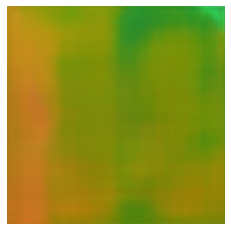

In [22]:
# Test representation on test image

#filename = os.path.join(os.environ['DATADIR'], 'line_world_data', 'real', 'validation.hdf5')
#h5py_file = h5py.File(filename, 'r')
#dataset = Dataset()
#dataset.extend(h5py_file['dataset'])
#image = dataset.observations[0]
image = Image.open('/Users/kelchtermans/mount/ubuntu/home/klaas/code/imitation-learning-codebase/experimental_data/line_world_real2/concrete_bluecable/raw_data/20-07-24_11-22-29_joystick/observation/001595582561766.jpg')

o_t = TF.to_tensor(TF.resize(image, 256)) * 2 - 1
o_t = o_t[:3, :, :]
o_t = o_t.unsqueeze_(0)

# predict normals
feature_type = 'normal'
# Transform to normals feature
representation = visualpriors.representation_transform(o_t, feature_type, device='cpu') # phi(o_t) in the diagram below

# Transform to normals feature and then visualize the readout
pred = visualpriors.feature_readout(o_t, feature_type, device='cpu')

# Save it
#TF.to_pil_image(pred[0] / 2. + 0.5).save('test_{}_readout.png'.format(feature_type))
plt.imshow((pred[0] / 2. + 0.5).detach().numpy().swapaxes(0,1).swapaxes(1,2))
plt.axis('off')
plt.show()